### Step 1: Imports

In [24]:
# Import libraries and packages

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kruskal

Load the dataset `df_1.csv` as data and display the first five rows.

In [25]:
data = pd.read_csv('df_1.csv')

data.head()

,Unnamed: 0,Entity,Year,Records,Organization type,Method,Sources
0,0,21st Century Oncology,2016,2200000,healthcare,hacked,[5][6]
1,1,500px,2020,14870304,social networking,hacked,[7]
2,2,Accendo Insurance Co.,2020,175350,healthcare,poor security,[8][9]
3,3,Adobe Systems Incorporated,2013,152000000,tech,hacked,[10]
4,4,Adobe Inc.,2019,7500000,tech,poor security,[11][12]


### Step 2: Clean the data

There is a value called `Sources` that will not be useful in our EDA. Therefore, we clean it using `del` keyword.

In [26]:
del data['Sources']
data

,Unnamed: 0,Entity,Year,Records,Organization type,Method
0,0,21st Century Oncology,2016,2200000,healthcare,hacked
1,1,500px,2020,14870304,social networking,hacked
2,2,Accendo Insurance Co.,2020,175350,healthcare,poor security
3,3,Adobe Systems Incorporated,2013,152000000,tech,hacked
4,4,Adobe Inc.,2019,7500000,tech,poor security
...,...,...,...,...,...,...
347,347,Zynga,2019,173000000,social network,hacked
348,348,Unknown agency(believed to be tied to United S...,2020,200000000,financial,accidentally published
349,349,National Health Information Center (NCZI) of S...,2020,391250,healthcare,poor security
350,350,50 companies and government institutions,2022,6400000,various,poor security


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         352 non-null    int64 
 1   Entity             352 non-null    object
 2   Year               352 non-null    object
 3   Records            350 non-null    object
 4   Organization type  352 non-null    object
 5   Method             351 non-null    object
dtypes: int64(1), object(5)
memory usage: 16.6+ KB


We can see that we have 352 rows and 6 columns. It's also visible a column named `"Unnamed: 0"`. Let's transform it into `"Index"`, using `rename()` method

In [28]:
data = data.rename(columns={'Unnamed: 0': 'Index'})

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Index              352 non-null    int64 
 1   Entity             352 non-null    object
 2   Year               352 non-null    object
 3   Records            350 non-null    object
 4   Organization type  352 non-null    object
 5   Method             351 non-null    object
dtypes: int64(1), object(5)
memory usage: 16.6+ KB


For now, only `Index` is an `integer`. Columns like `Year` and `Records` are `object`. Later on, we will see why. Let's check for duplicates, using `.duplicated()` method.

In [30]:
data.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
347    False
348    False
349    False
350    False
351    False
Length: 352, dtype: bool

### Step 3: Sort the data

Sort the data to see which is the last year in the dataset. 

In [31]:
data.sort_values(by="Year", ascending=False).head(10)

,Index,Entity,Year,Records,Organization type,Method
351,351,IKEA,2022,95000,retail,accidentally published
151,151,International Committee of the Red Cross,2022,515000,humanitarian,unknown
350,350,50 companies and government institutions,2022,6400000,various,poor security
148,148,Iberdrola,2022,1300000,energy,poor security
195,195,Morinaga Confectionery,2022,1648922,online shopping,ransomware hacked
200,200,"NEC Networks, LLC",2021,1600000,healthcare,hacked
77,77,CyberServe,2021,1107034,hosting provider,hacked
282,282,T-Mobile,2021,45000000,telecom,hacked
140,140,Health Service Executive,2021,unknown,healthcare,unknown
289,289,Twitch,2021,unknown,tech,hacked/misconfiguration


Sort the data according to the highest number of attacks in the given years.

In [32]:
data["Year"].value_counts().sort_values(ascending=False)

Year
2011             34
2020             31
2019             30
2013             28
2015             28
2018             26
2014             25
2012             23
2016             22
2010             19
2008             16
2021             13
2009             13
2007             12
2017              9
2006              7
2005              6
2022              5
2004              2
2019-2020         1
2018-2019         1
2014 and 2015     1
Name: count, dtype: int64

### Step 4: Clean the data

As EDA allows for returning to a previous step, we'll continue with data cleaning. The reason is there are three values that determine the `object` dtype of `Year` column. These values are: "2019-2020", "2018-2020" and "2014 and 2015".
A separate column called `Year_Split`will be created to store the object values, then `Year` column will be converted to `integer`.
Before this, we'll identify the index of these values and retrieve more information about them.

In [33]:
"""
Let's breakdown the code:

value_to_find = "2019-2020" stores the target value we want to find in the dataset.

result = data.where(data == value_to_find).dropna(how='all').dropna(how='all').dropna(axis=1, how='all') The .where() method is used to create a new DataFrame called "result", by comparing each cell in the original "data" (which is the dataframe)
If a cell matches, it keeps the original value.
If a cell doesn't match, it replaces the value with NaN (Not a Number), essentially marking non-matching cells.
.dropna(how='all').dropna(axis=1, how='all') cleans up the "result" DataFrame:
.dropna(how='all') Removes rows where all values are NaN. This ensures that if "2019-2020" isn't found in a row, the entire row is discarded.
.dropna(axis=1, how='all'): Does the same thing but for columns. If a column has all NaN values (meaning "2019-2020" wasn't found in that column), the entire column is removed.

row_index = result.index[0]: After the cleanup, "result" should ideally contain a single cell with the value "2019-2020." This line extracts the row index of that cell.

column_index = result.columns[0]: Similarly, this line extracts the column index of the cell containing "2019-2020."

print(f"Row index: {row_index}, Column index: {column_index}"): Finally, the code prints the row and column indices where the target value was found in the original "data."

"""

value_to_find = "2019-2020" 
result = data.where(data == value_to_find).dropna(how='all').dropna(axis=1, how='all')
row_index = result.index[0]
column_index = result.columns[0]

print(f"Row index: {row_index}, Column index: {column_index}") 

Row index: 94, Column index: Year


In [34]:
row_label = 94  # The index label of the row we want
selected_row = data.loc[row_label] # assigns the selected row (which is a Pandas Series) to the variable row_label, which holds the label of the row we are selecting, i.e 94 in our case

selected_row

Index                                                               94
Entity                                                         EasyJet
Year                                                         2019-2020
Records              9,000,000 (approx) - basic booking, 2208 (cred...
Organization type                                            transport
Method                                                          hacked
Name: 94, dtype: object

In [35]:
row_label = 96 
selected_row = data.loc[row_label]

selected_row

Index                                                               96
Entity               Earl Enterprises(Buca di Beppo, Earl of Sandwi...
Year                                                         2018-2019
Records                                                        2000000
Organization type                                           restaurant
Method                                                          hacked
Name: 96, dtype: object

In [36]:
value_to_find = "2014 and 2015"
result = data.where(data == value_to_find).dropna(how='all').dropna(axis=1, how='all')
row_index = result.index[0]
column_index = result.columns[0]

print(f"Row index: {row_index}, Column index: {column_index}")

Row index: 144, Column index: Year


In [37]:
row_label = 144  
selected_row = data.loc[row_label]

selected_row

Index                          144
Entity               Hilton Hotels
Year                 2014 and 2015
Records                     363000
Organization type            hotel
Method                      hacked
Name: 144, dtype: object

Now, we'll create define a function that uses conditional checks to handle different year formats.


Code breakdown:

`extract_year_split(year_string)` function takes a single `year_string` as input.
It uses conditional checks (`if`, `elif`, `else`) to handle different year formats:


`if 'and' in year_string:`: If the string contains "and", it replaces " and " with " and " (it seems like you might have intended a different replacement here).

`elif '-' in year_string:`: If the string contains "-", it replaces " - " with " - " (again, the replacement seems unintentional).

`else:`: If neither "and" nor "-" is found, it keeps the year_string as is (this likely handles the "YYYY-YYYY" format).

Finally, it returns the modified `year_string`.



Creating the `Year_Split` Column:
 

`mask = data['Year'].str.contains(r'\d{4}-\d{4}|\band\b')` creates a boolean mask (mask) to identify rows where the "Year" column matches specific patterns:
`\d{4}-\d{4}` Matches strings like "YYYY-YYYY".
`\band\b` Matches strings containing "and" as a separate word (the `\b` ensures it's not part of another word).

`data['Year_Split'] = data.loc[mask, 'Year'].apply(extract_year_split)` applies the extract_year_split function to the "Year" column only for rows where the mask is True (i.e., rows matching the year patterns). The results are stored in a new column called `Year_Split`.
`data.loc[mask, 'Year'] = None` sets the original "Year" values to None for the rows where the mask is True. This suggests we might want to eventually remove the original `Year` column.

`print(data)`  prints the modified DataFrame, showing the results of the transformation.



In [38]:

def extract_year_split(year_string):
    if 'and' in year_string:
        return year_string.replace(' and ', ' and ')
    elif '-' in year_string:
        return year_string.replace (' - ', ' - ')
    else:
        return year_string  # Keep "YYYY-YYYY" as is

mask = data['Year'].str.contains(r'\d{4}-\d{4}|\band\b')
data['Year_Split'] = data.loc[mask, 'Year'].apply(extract_year_split)
data.loc[mask, 'Year'] = None

print(data)

     Index                                             Entity  Year  \
0        0                              21st Century Oncology  2016   
1        1                                              500px  2020   
2        2                              Accendo Insurance Co.  2020   
3        3                         Adobe Systems Incorporated  2013   
4        4                                         Adobe Inc.  2019   
..     ...                                                ...   ...   
347    347                                              Zynga  2019   
348    348  Unknown agency(believed to be tied to United S...  2020   
349    349  National Health Information Center (NCZI) of S...  2020   
350    350           50 companies and government institutions  2022   
351    351                                               IKEA  2022   

       Records  Organization type                  Method Year_Split  
0      2200000         healthcare                  hacked        NaN  
1    

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Index              352 non-null    int64 
 1   Entity             352 non-null    object
 2   Year               349 non-null    object
 3   Records            350 non-null    object
 4   Organization type  352 non-null    object
 5   Method             351 non-null    object
 6   Year_Split         3 non-null      object
dtypes: int64(1), object(6)
memory usage: 19.4+ KB


The column `Year_Split` was created and contains 3 objects. Meanwhile, `Year` has 349, instead of 352. Exactly what we wanted to achieve. Let's describe the data.

In [40]:
data['Year'].describe()

count      349
unique      19
top       2011
freq        34
Name: Year, dtype: object

Explanation:
- count: There are 349 non-missing values in this column.
- unique: There are 19 distinct (different) categories or values in this column.
- top: The most frequent value (the mode) in this column is '2011'.
-freq: The most frequent value ('2011') appears 34 times in the dataset.

In [41]:
data['Organization type'].describe()

count     352
unique     70
top       web
freq       53
Name: Organization type, dtype: object

Now, let's create a copy of the original data frame and convert the values from column `Year`. Then we describe it again, this time as an integer.

In [42]:
data_copy = data.copy()


data_copy['Year'] = data['Year'].fillna(0).astype(int)
data_copy.head()

,Index,Entity,Year,Records,Organization type,Method,Year_Split
0,0,21st Century Oncology,2016,2200000,healthcare,hacked,NaN
1,1,500px,2020,14870304,social networking,hacked,NaN
2,2,Accendo Insurance Co.,2020,175350,healthcare,poor security,NaN
3,3,Adobe Systems Incorporated,2013,152000000,tech,hacked,NaN
4,4,Adobe Inc.,2019,7500000,tech,poor security,NaN


Explanation:
- count: There are 352 non-missing values in the 'Year' column.
- mean: The average year is approximately 1996.96. This suggests that the years in the dataset are centered around the late 1990s/early 2000s.
- std (standard deviation): The standard deviation is about 185.46. This tells  how spread out the years are around the mean. A larger standard deviation indicates a wider range of years.
- min: The earliest year in the dataset is 0. This value might indicate either missing data or a placeholder, as the year 0 is not a standard calendar year.
- 25% (1st quartile): 25% of the years in the dataset are 2011 or earlier.
- 50% (median): The middle year in the dataset is 2014. This means that half of the years are before 2014, and half are after.
- 75% (3rd quartile): 75% of the years in the dataset are 2018 or earlier.    
- max: The most recent year in the dataset is 2022.

Note that now we have again 352 rows in the `Year` column. That's because after converting to integer, the rows moved to `Year_Split` were re-added. The value 0 is due to the missing values in The `Year` column. Let's `index 96` as an example.

In [43]:
row_label = 96 
selected_row = data.loc[row_label]

selected_row

Index                                                               96
Entity               Earl Enterprises(Buca di Beppo, Earl of Sandwi...
Year                                                              None
Records                                                        2000000
Organization type                                           restaurant
Method                                                          hacked
Year_Split                                                   2018-2019
Name: 96, dtype: object

There is a way to get rid of the 0 value which does not make sense in our EDA.

In [44]:
data_copy = data_copy[data_copy['Year'] != 0] 
data_copy.head(96)

,Index,Entity,Year,Records,Organization type,Method,Year_Split
0,0,21st Century Oncology,2016,2200000,healthcare,hacked,NaN
1,1,500px,2020,14870304,social networking,hacked,NaN
2,2,Accendo Insurance Co.,2020,175350,healthcare,poor security,NaN
3,3,Adobe Systems Incorporated,2013,152000000,tech,hacked,NaN
4,4,Adobe Inc.,2019,7500000,tech,poor security,NaN
...,...,...,...,...,...,...,...
91,91,DSW Inc.,2005,1400000,retail,hacked,NaN
92,92,Dubsmash,2018,162000000,messaging app,hacked,NaN
93,93,Dun & Bradstreet,2013,1000000,tech,hacked,NaN
95,95,eBay,2014,145000000,web,hacked,NaN


In [45]:
data_copy['Year'].describe()

count     349.000000
mean     2014.123209
std         4.415133
min      2004.000000
25%      2011.000000
50%      2014.000000
75%      2018.000000
max      2022.000000
Name: Year, dtype: float64

Check the integrity of the rows that have a corresponding value in `Year_Split` column.

In [46]:
row_label = 94 
selected_row = data.loc[row_label]

selected_row

Index                                                               94
Entity                                                         EasyJet
Year                                                              None
Records              9,000,000 (approx) - basic booking, 2208 (cred...
Organization type                                            transport
Method                                                          hacked
Year_Split                                                   2019-2020
Name: 94, dtype: object

Create a data frame only for rows that have a value in `Year_Split`

In [47]:
data_split = data[data['Year_Split'].notna()].copy()
data_split.head()

,Index,Entity,Year,Records,Organization type,Method,Year_Split
94,94,EasyJet,None,"9,000,000 (approx) - basic booking, 2208 (cred...",transport,hacked,2019-2020
96,96,"Earl Enterprises(Buca di Beppo, Earl of Sandwi...",None,2000000,restaurant,hacked,2018-2019
144,144,Hilton Hotels,None,363000,hotel,hacked,2014 and 2015


### Step 5: Sample the data

Select a sample of 40 rows and set a seed of 32 for the number generator. Using a seed ensures that we get the same random sample each time we run the code. If you don't set a seed, we'll get a different random sample every time.

In [48]:
random_companies = data_copy.sample(n=40, random_state = 32)

random_companies.shape

(40, 7)

### Step 6: Analyze the data

Group number of attacks data by year and organization type, counts the number of attacks within each group, and then presents this information in a new DataFrame called `attacks_by_year`. This DataFrame provides a clear overview of how many attacks each organization type experienced in each year.

Identify how many rows in the dataset have the same `Year` and `Organizaton type` as other rows.

In [49]:
duplicates = random_companies[random_companies.duplicated(subset=['Year', 'Organization type'], keep=False)]
duplicates.shape

(9, 7)

Calculate the number of attacks for **each unique combination** of `Year` and `Organization type` in `random_companies`

In [50]:
attacks_by_year = random_companies.groupby(['Year', 'Organization type']).size().reset_index(name='Number of Attacks')
attacks_by_year.shape

(35, 3)

Group the attack data by `Year_Split`  and `Organization type`, count the attacks within each group, and present this information in a new DataFrame called `attacks_by_year_split`. This allows us to analyze attack trends based on the `Year_Split` categorization.

In [51]:
attacks_by_year_split = data_split.groupby(['Year_Split', 'Organization type']).size().reset_index(name='Number of Attacks')
attacks_by_year_split

,Year_Split,Organization type,Number of Attacks
0,2014 and 2015,hotel,1
1,2018-2019,restaurant,1
2,2019-2020,transport,1



1. `split_and_sum(df)` takes the DataFrame (`data`) and processes rows where the `Year_Split` column contains combined years. It splits these entries into separate rows while preserving the attack counts.
How it works:
- It iterates through each row of the DataFrame.
- If "and" is found in the `Year_Split` value:
- It splits the `Year_Split` string into individual years.
- For each extracted year, it creates a new row that's a copy of the original row but with the `Year_Split` set to the individual year.
- If "and" is not found, it keeps the row as is.
  
Output: The function returns a new DataFrame (`all_rows`) where combined year entries are expanded into separate rows.

2. Applying the Function and Aggregating:

`attacks_expanded = split_and_sum(attacks_by_year_split) 
attacks_final = attacks_expanded.groupby('Year_Split').agg({
    'Organization type': ', '.join,
    'Number of Attacks': 'sum'
}).reset_index()`

`attacks_expanded = `:  applies the split_and_sum function to your original DataFrame (presumably named attacks_by_year_split), which likely contains the combined year entries. The result is stored in attacks_expanded.

`attacks_final = `:  further processes the expanded DataFrame:

`groupby('Year_Split')`:  groups the data by the now-separated 'Year_Split' values.

`.agg({...})`: performs aggregation within each year group:

`Organization type`: ', '.join: For each year, it combines the unique "Organization type" values into a single string, separated by commas.

`Number of Attacks`: 'sum':  sums up the 'Number of Attacks' for each year.

`.reset_index()`:  resets the index, making 'Year_Split' a regular column again.



3. `attacks_final.head()`: displays the first few rows of the final processed DataFrame (attacks_final). This DataFrame should now have a clean structure with each row representing a unique year, the associated organization types attacked that year, and the total number of attacks.


In [52]:

def split_and_sum(data):
    """Splits 'and' years, aggregates, and maintains attack counts."""
    all_rows = []
    for index, row in data.iterrows():
        if 'and' in row['Year_Split']:
            years = row['Year_Split'].split(' and ')
            for year in years:
                new_row = row.copy()
                new_row['Year_Split'] = year
                all_rows.append(new_row)
        else:
            all_rows.append(row)
    return pd.DataFrame(all_rows)

attacks_expanded = split_and_sum(attacks_by_year_split)
attacks_final = attacks_expanded.groupby('Year_Split').agg({
    'Organization type': ', '.join,
    'Number of Attacks': 'sum'
}).reset_index()

attacks_final.head()


,Year_Split,Organization type,Number of Attacks
0,2014,hotel,1
1,2015,hotel,1
2,2018-2019,restaurant,1
3,2019-2020,transport,1


Combine `attacks_by_year` and `attacks_by_year_split` 

In [53]:
combined_attacks = pd.concat([attacks_by_year, attacks_by_year_split])

combined_attacks.shape

(38, 4)

There are 38 rows and 4 columns. This is exactly what we needed, 3 new rows were joined to the initial 35 rows resulted from grouping.

Now, group the combined_attacks DataFrame by "Organization type" and calculate the total number of attacks for each type, storing the result in the `total_attacks` Series.
Find the index label (the "Organization type") with the maximum value (highest number of attacks) in the `total_attacks` Series. The result is stored in `most_attacked_type`.
Then find the maximum value (highest number of attacks) itself from the `total_attacks` Series. The result is stored in `max_attacks`.

### Step 7: Results and evaluation

In [54]:
total_attacks = combined_attacks.groupby('Organization type')['Number of Attacks'].sum()


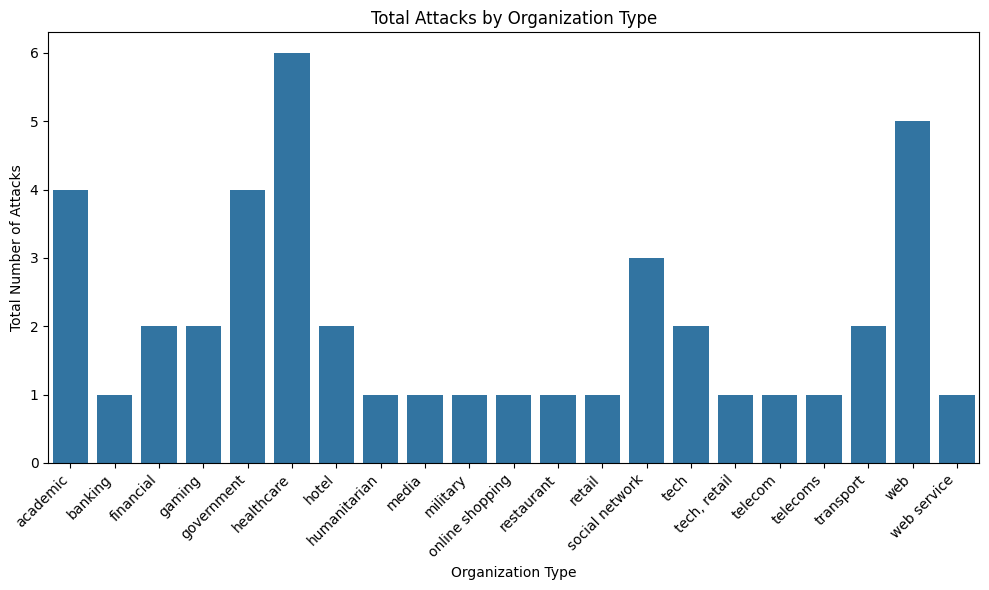

In [55]:
plt.figure(figsize=(10, 6)) 
sns.barplot(x=total_attacks.index, y=total_attacks.values)

plt.xlabel('Organization Type')
plt.ylabel('Total Number of Attacks')
plt.title('Total Attacks by Organization Type')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

Calculate the total attacks for each organization type, and identify the organization type with the most attacks.

In [56]:
most_attacked_type = total_attacks.idxmax()
max_attacks = total_attacks.max()
print(f"The organization type with the most attacks is '{most_attacked_type}' with {max_attacks} attacks.")

The organization type with the most attacks is 'healthcare' with 6 attacks.


Calculate the total attacks for each organization type, and identify the organization type with the fewest attacks.

In [57]:
least_attacked_type = total_attacks.idxmin()
min_attacks = total_attacks.min()

print(f"The organization type with the least attacks is '{least_attacked_type}' with {min_attacks} attacks.")

The organization type with the least attacks is 'banking' with 1 attacks.


In [58]:
"""

Perform a Shapiro-Wilk test to assess whether the data in the 'Number of Attacks' column of your combined_attacks DataFrame is normally distributed.

data = combined_attacks['Number of Attacks'] extract the data from the 'Number of Attacks' column of your DataFrame and stores it in the variable data.
statistic, p_value = stats.shapiro(data) perform the Shapiro-Wilk test using the shapiro() function from the scipy.stats module. 

The shapiro() function takes the data as input. It returns two values: statistic: The Shapiro-Wilk test statistic (W), which measures how well the data fits a normal distribution.
#p_value"The probability of observing the data (or more extreme data) if the data were truly normally distributed.

"""



data = combined_attacks['Number of Attacks'] 


statistic, p_value = stats.shapiro(data) 

# Print the results
print(f"Shapiro-Wilk Statistic: {statistic:.3f}")
print(f"P-value: {p_value:.3f}")

# Interpret the results
alpha = 0.05  # Set the significance level
if p_value > alpha:
    print("Data looks normally distributed (fail to reject H0)")
else:
    print("Data does not look normally distributed (reject H0)")

Shapiro-Wilk Statistic: 0.361
P-value: 0.000
Data does not look normally distributed (reject H0)


In [59]:
"""

This line creates a list called groups. Each element in this list is a Pandas Series containing the 'Number of Attacks' for a specific 'Organization type'.
It iterates through each unique 'Organization type' found in the attacks_by_year DataFrame.
For each org_type, it selects the 'Number of Attacks' from the combined_attacks DataFrame where the 'Organization type' matches the current org_type.

"""

groups = [combined_attacks['Number of Attacks'][combined_attacks['Organization type'] == org_type] 
          for org_type in attacks_by_year['Organization type'].unique()]

# Perform the Kruskal-Wallis test
statistic, p_value = kruskal(*groups)

alpha = 0.05  # Set the significance level
if p_value > alpha:
    print("No significant difference between groups (fail to reject H0)")
else:
    print("Significant difference between at least two groups (reject H0)")

No significant difference between groups (fail to reject H0)
